In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az
import statsmodels.api as sm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/wenyun/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
number_data_point = 5000

# A probabilistic generator for tao
tao = 10
phi = np.exp(-1/tao)

quantization = 255 # 8 bit image

intensity_mean = 80
intensity_std = 20

# A probabilistic generator for the innovation term.
innovation_mean = intensity_mean*(1-phi) # this is the c term in the wikipedia construction
innovation_std = intensity_std*np.sqrt(1-phi**2) # this is the standard deviation of the innovation 
innovation = np.random.normal(loc=0.0, scale=innovation_std, size = number_data_point)

intensity_variance = intensity_std**2 # this is the expectation value of all intensity signals

print('The set mean of intensity is {}'.format(intensity_mean))
print('The set std of intensity is {}'.format(intensity_std))
print('The set mean of innovation is {}'.format(innovation_mean))
print('The set std of innovation is {}'.format(innovation_std))

The set mean of intensity is 80
The set std of intensity is 20
The set mean of innovation is 7.613006557123239
The set std of innovation is 8.515145258232963


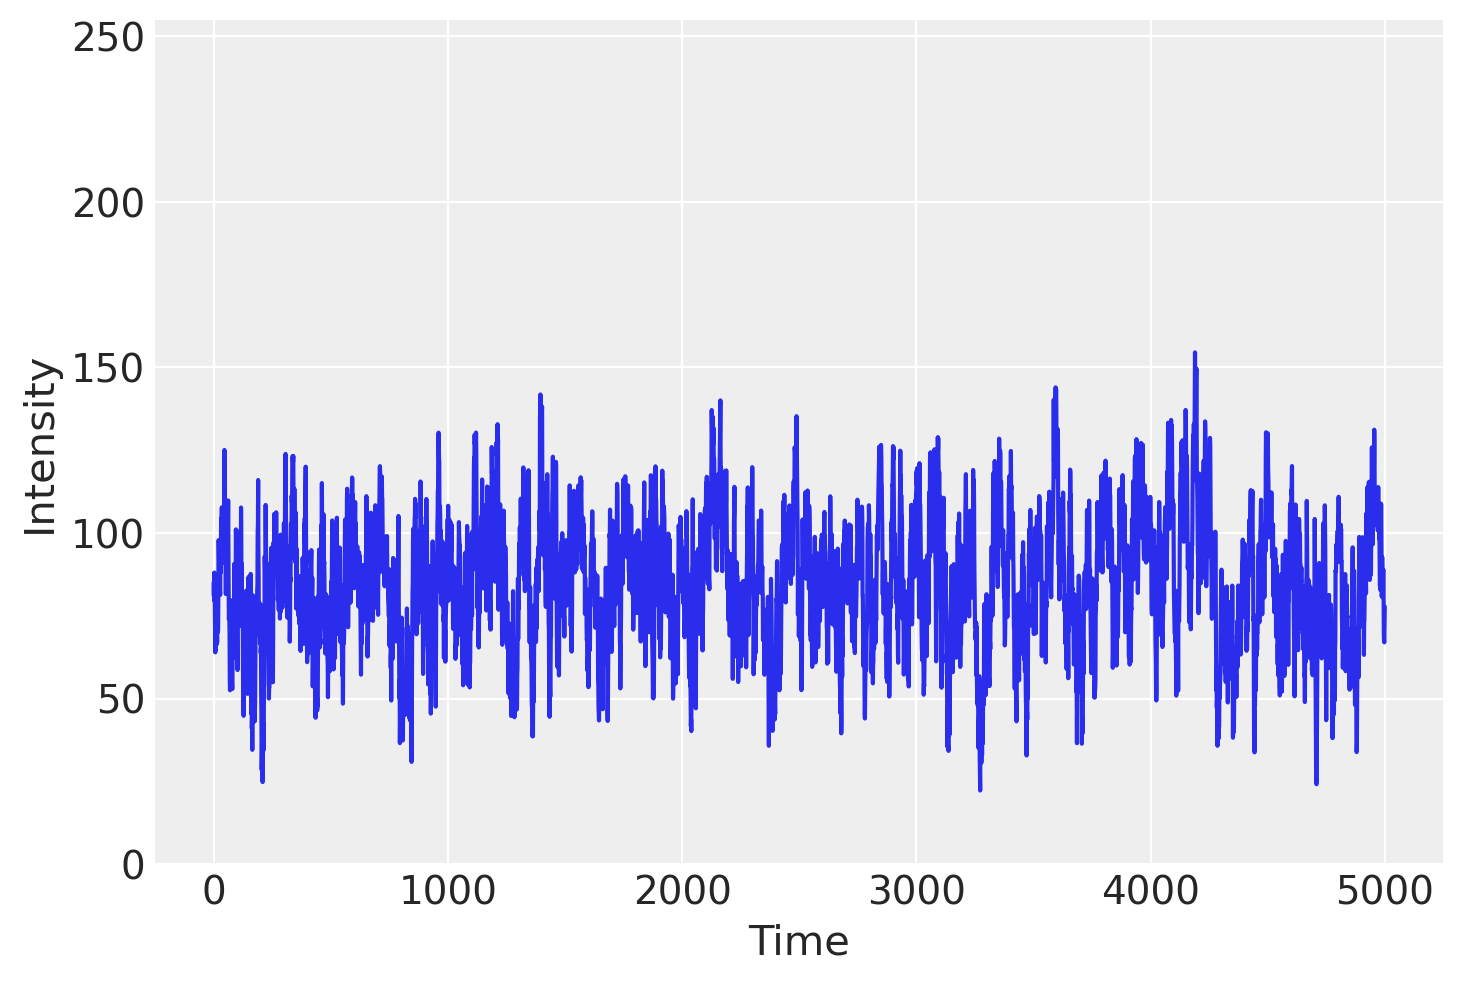

the mean of simulated data is 85.06708870827612
the std of simulated data is 19.445977387325158


In [4]:
#Generate simulated data with statsmodel

ar = np.r_[1, -phi] # add zero-lag and negate
ma = np.r_[1] # add zero-lag
X_statsmodel_generated = sm.tsa.arma_generate_sample(ar, ma, number_data_point, scale=innovation_std)

X = X_statsmodel_generated + intensity_mean

#Add camera noise
camera_noise_mean = 5
camera_noise_std = 1
camera_noise = np.random.normal(loc = camera_noise_mean, scale = camera_noise_std, size = number_data_point)

X_simulated_data = X+camera_noise

#Plot simulated data

plt.plot(np.arange(number_data_point),X_simulated_data,'-')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.ylim([0,quantization])
plt.show()

print('the mean of simulated data is {}'.format(np.average(X_simulated_data)))
print('the std of simulated data is {}'.format(np.std(X_simulated_data)))

In [5]:
# Bayesian parameter estimation with pymc3
ar1_model = pm.Model()

with ar1_model:
    
    # 'phi'is ln(-1/tau) used in our generative model
    decay_time = pm.Uniform("decay_time",lower = 0, upper = 50) 
    stationarity = np.exp(-1/decay_time)
    # 'precision' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
    precision_AR1 = pm.Uniform("precision", lower = 0 , upper = 1) 
    # process mean
    center = pm.Uniform("center", lower = 0, upper = quantization) # this is the mean of normalized data
   
    
    likelihood = pm.AR1("y", k=stationarity, tau_e=precision_AR1, observed = X_simulated_data - center)

In [6]:
estimate = pm.find_MAP(model = ar1_model)

In [7]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_14519/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17800
Interrupted at 17,799 [8%]: Average Loss = 37,964
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [center, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


/Users/wenyun/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:213: UserWarning: A valid var_name should be provided, found {'noise_mean', 'noise_std'} expected from {'center', 'precision', 'decay_time'}
  warnings.warn(


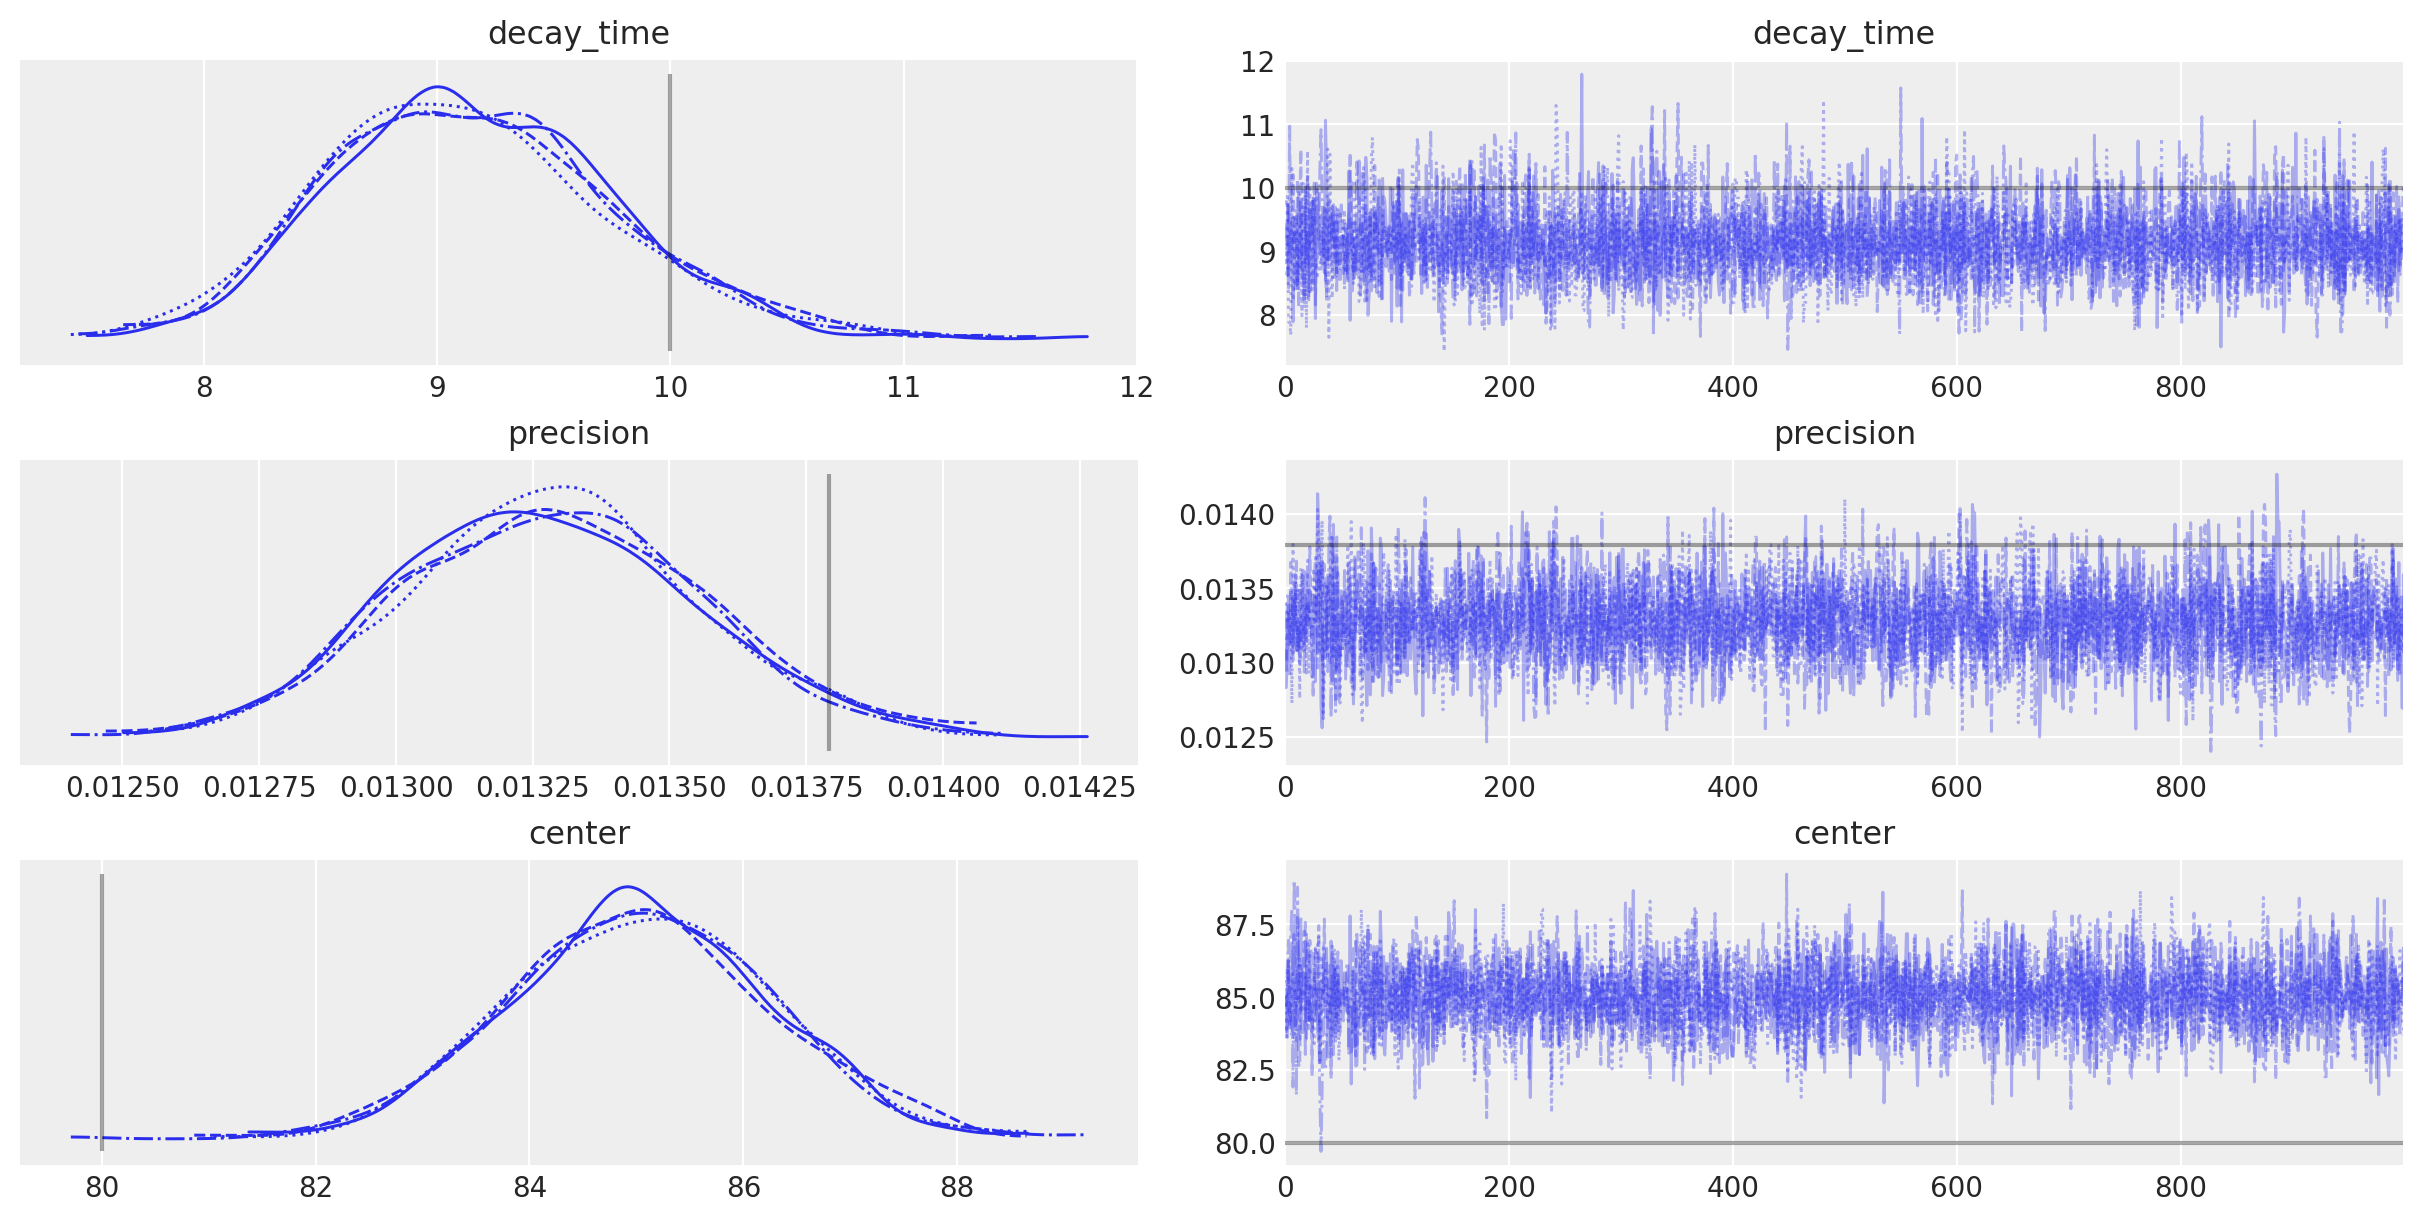

In [8]:
az.plot_trace(
    idata,
    lines=[
        ("decay_time", {}, tao),
        ("precision", {}, 1/(innovation_std**2)),
        ("center", {}, intensity_mean),
        ("noise_mean", {}, camera_noise_mean),
        ("noise_std", {}, camera_noise_std),
    ],
);